<a href="https://colab.research.google.com/github/Sireesiru/Cryo-EM-Ultrastructures/blob/main/Github_FOV_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ultralytics
!pip install scikit-image

,Bacterium_ID,Confidence,Centroid_X,Centroid_Y,BBox_X1,BBox_Y1,BBox_X2,BBox_Y2,Area_px2,Area_nm2
0,1,0.834592,835.321429,374.785714,831.474121,368.946259,840.762451,378.317291,112.0,1.717615e+06
1,2,0.830266,676.183007,322.810458,670.891479,317.444855,682.194946,326.999786,153.0,2.346385e+06
2,3,0.818671,556.702381,306.988095,551.341431,302.534729,562.574219,311.575012,168.0,2.576423e+06
3,4,0.799187,570.467532,428.766234,564.743408,423.776764,576.788330,435.506866,154.0,2.361721e+06
4,5,0.796796,744.954545,687.136364,739.731873,682.093445,750.431580,690.829163,176.0,2.699110e+06


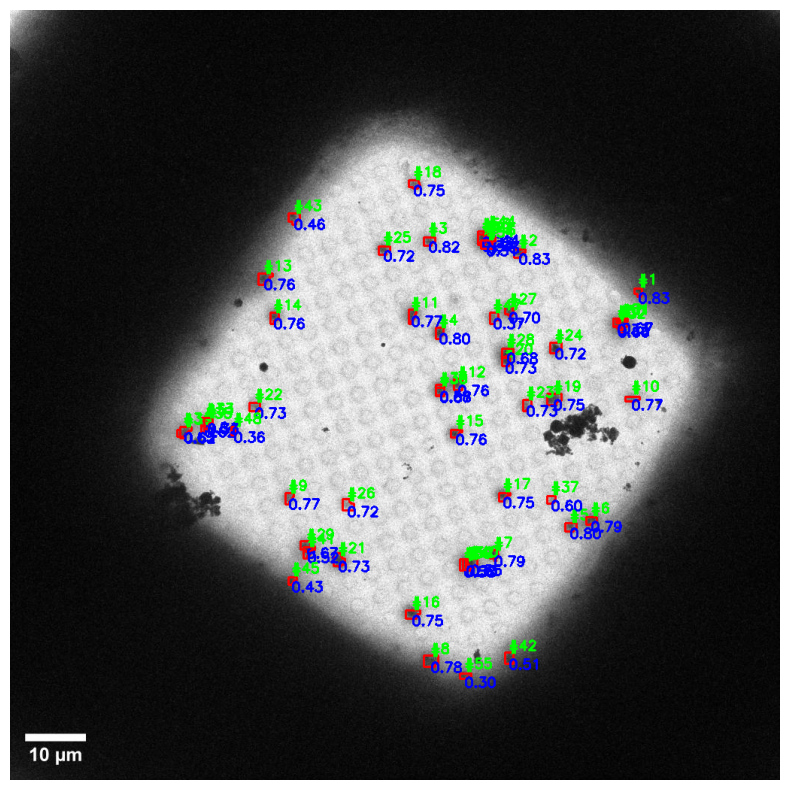

In [ ]:
######### Predict on test set and get quantitative properties like area, boundry boxes, prediction confidence of bacteria in pixels and nm PER IMAGE

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ultralytics import YOLO
from skimage.measure import regionprops, label

# -----------------------------
# Paths
# -----------------------------
MODEL_PATH ="/content/drive/MyDrive/YOLO_CRYO_EM/FOV_new/50_images/runs1/segment/train4/weights/best.pt"
IMAGE_PATH = '/content/drive/MyDrive/YOLO_CRYO_EM/FOV_new/50_images/test/images/18r-R2A_dyn_png.rf.9806a57a4d0d310cfa7e05b49d4593a1.jpg'

# -----------------------------
# Conversion factor (nm per px)
# -----------------------------
ORIG_SIZE = 4096
RESIZED_SIZE = 1024
PIXEL_SIZE_NM = 30.9595
NM_PER_PX = (ORIG_SIZE / RESIZED_SIZE) * PIXEL_SIZE_NM

# -----------------------------
# Load model and run inference
# -----------------------------
model = YOLO(MODEL_PATH)
results = model(IMAGE_PATH, verbose=False)[0]

# Load original image
image = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
overlay = image_rgb.copy()

records = []

if results.masks is not None:
    masks = results.masks.data.cpu().numpy()   # (N, H, W)
    boxes = results.boxes.xyxy.cpu().numpy()   # bounding boxes
    confs = results.boxes.conf.cpu().numpy()   # confidence scores

    for i, (mask, box, conf) in enumerate(zip(masks, boxes, confs), start=1):
        mask_uint8 = (mask > 0.5).astype(np.uint8)  # binary mask

        # Regionprops (requires labeled mask)
        props = regionprops(label(mask_uint8))

        if len(props) > 0:
            prop = props[0]   # one region per mask

            # Extract pixel-based features
            area_px = prop.area
            perimeter_px = prop.perimeter
            eccentricity = prop.eccentricity
            solidity = prop.solidity

            # Convert to nanometers
            area_nm2 = area_px * (NM_PER_PX ** 2)
            perimeter_nm = perimeter_px * NM_PER_PX

            # Centroid (x,y)
            cx, cy = prop.centroid[::-1]

            # Draw contour in red
            contours, _ = cv2.findContours((mask_uint8*255), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(overlay, contours, -1, (255, 0, 0), 2)

            # Label with ID and confidence
            cv2.putText(overlay, f"#{i}", (int(cx), int(cy)-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            cv2.putText(overlay, f"{conf:.2f}", (int(cx), int(cy)+15),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

            # Save to dataframe
            records.append({
                "Bacterium_ID": i,
                "Confidence": float(conf),
                "Centroid_X": float(cx),
                "Centroid_Y": float(cy),
                "BBox_X1": float(box[0]),
                "BBox_Y1": float(box[1]),
                "BBox_X2": float(box[2]),
                "BBox_Y2": float(box[3]),
                "Area_px2": area_px,
                "Area_nm2": area_nm2})

# -----------------------------
# DataFrame
# -----------------------------
df = pd.DataFrame(records)
display(df.head())

# -----------------------------
# Show overlay
# -----------------------------
plt.figure(figsize=(10, 10))
plt.imshow(overlay)
plt.axis("off")
plt.show()

In [ ]:
######### Repeat for all images in the test folder

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob, os
from ultralytics import YOLO
from skimage.measure import regionprops, label

# -----------------------------
# Paths
# -----------------------------
MODEL_PATH = "/content/drive/MyDrive/YOLO_CRYO_EM/FOV_new/50_images/runs1/segment/train4/weights/best.pt"
IMAGE_DIR = "/content/drive/MyDrive/YOLO_CRYO_EM/FOV_new/50_images/test/images"
output_folder = "/content/drive/MyDrive/YOLO_CRYO_EM/FOV_new/50_images/output"

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)


# -----------------------------
# Conversion factor (nm per px)
# -----------------------------
ORIG_SIZE = 4096
RESIZED_SIZE = 1024
PIXEL_SIZE_NM = 30.9595
NM_PER_PX = (ORIG_SIZE / RESIZED_SIZE) * PIXEL_SIZE_NM

# -----------------------------
# Load YOLO model
# -----------------------------
model = YOLO(MODEL_PATH)

# -----------------------------
# Process all images
# -----------------------------
image_paths = glob.glob(os.path.join(IMAGE_DIR, "*.[pj][np]g")) + \
              glob.glob(os.path.join(IMAGE_DIR, "*.tif")) + \
              glob.glob(os.path.join(IMAGE_DIR, "*.tiff"))

for img_path in image_paths:
    base = os.path.splitext(os.path.basename(img_path))[0]
    folder = os.path.dirname(img_path)
    print(f"Processing {base} ...")

    # Run YOLO inference
    results = model(img_path, verbose=False)[0]

    # Load original image
    image = cv2.imread(img_path)
    if image is None:
        print(f"Could not read {img_path}, skipping.")
        continue
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    overlay = image_rgb.copy()

    records = []

    if results.masks is not None:
        masks = results.masks.data.cpu().numpy()
        boxes = results.boxes.xyxy.cpu().numpy()
        confs = results.boxes.conf.cpu().numpy()

        for i, (mask, box, conf) in enumerate(zip(masks, boxes, confs), start=1):
            mask_uint8 = (mask > 0.5).astype(np.uint8)

            props = regionprops(label(mask_uint8))
            if len(props) == 0:
                continue

            prop = props[0]

            # Pixel-based features
            area_px = prop.area
            perimeter_px = prop.perimeter
            eccentricity = prop.eccentricity
            solidity = prop.solidity

            # Convert to nm
            area_nm2 = area_px * (NM_PER_PX ** 2)
            perimeter_nm = perimeter_px * NM_PER_PX

            # Centroid
            cx, cy = prop.centroid[::-1]

            # Draw contour and ID on overlay
            contours, _ = cv2.findContours((mask_uint8*255), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(overlay, contours, -1, (255, 0, 0), 2)
            cv2.putText(overlay, f"#{i}", (int(cx), int(cy)-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            cv2.putText(overlay, f"{conf:.2f}", (int(cx), int(cy)+15),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

            # Save record
            records.append({
                "Image": base,
                "Bacterium_ID": i,
                "Confidence": float(conf),
                "Centroid_X": float(cx),
                "Centroid_Y": float(cy),
                "BBox_X1": float(box[0]),
                "BBox_Y1": float(box[1]),
                "BBox_X2": float(box[2]),
                "BBox_Y2": float(box[3]),
                "Area_px2": area_px,
                "Area_nm2": area_nm2})

    # Save per-image CSV
    df = pd.DataFrame(records)
    csv_path = os.path.join(output_folder, f"{base}_FOV_metrics.csv")
    df.to_csv(csv_path, index=False)

    # Save overlay figure
    plt.figure(figsize=(10, 10))
    plt.imshow(overlay)
    plt.axis("off")
    plt.title(f"{base} - YOLO Segmentation")
    plt.tight_layout()
    overlay_path = os.path.join(output_folder, f"{base}_overlay.png")
    plt.savefig(overlay_path, dpi=150)
    plt.close()

Processing 7-MOPSglu_dyn_png.rf.559d3b5b4395ec4c0d2c8b8fa8ba34cf ...
Processing 2-MOPSglu_dyn_png.rf.2c57139c92ca0088686a7b0c53f6239a ...
Processing 18r-R2A_dyn_png.rf.9806a57a4d0d310cfa7e05b49d4593a1 ...
Processing 3-MOPSglu_dyn_png.rf.03a318970b9ef7f2ad0e3f4fa08d51e9 ...
Processing 8r-R2A_dyn_png.rf.29b093ff0e323c61575d050c44d03d9d ...
Processing 17s-MOPSsuc_dyn_png.rf.3d439654f6aa088ec49acfe93d235453 ...
Processing 20s-MOPSsuc_dyn_png.rf.2b337110fad5590d48c00baa0e3cee35 ...
Processing 13s-MOPSsuc_dyn_png.rf.a208bbaa86110b0d928056cba14fc34d ...
Processing 15r-R2A_dyn_png.rf.fd0ac421729f3ffc9ce1e2072e08e3c7 ...
Processing 10-MOPSglu_dyn_png.rf.e13ae8172c0f6065bd91370b403029a5 ...
